In [1]:
# Simulation length and resolution
dx <- 0.05 # step size
max_time <- 15 # time horizon
xx <- seq(0, max_time, dx)
nn <- length(xx)


# Generation distribution
rbase <- function(n) rgamma(n, theta1, theta2)
dbase <- function(n) dgamma(n, theta1, theta2)
pbase <- function(n) pgamma(n, theta1, theta2)

# specify parameters for generation interval
theta1 <- 5
theta2 <- 6

g <- pbase(xx[2:nn]) - pbase(xx[1:(nn-1)]) # precompute generation intervals in the bins
g <- c(g, 1-sum(g)) # ensure sum to 1
G <- 1 - pbase(xx) # survival function


# Time-varying reproduction number
R0 <- 1.3
Rt <- function(x) {
  R0 + sin(0.5 * x)
}


# Reproduction number and generation time arrays
A <- matrix(0, nrow = nn, ncol = nn) # initialise Rt matrix
C <- matrix(NA, nrow = nn, ncol = nn) # initialise g matrix

for(i in 1:nn){
  A[,i] <- Rt(pmax(0, xx-xx[i])) # populate Rt matrix
  C[i,] <- g # populate g matrix
}

A[upper.tri(A)] <- 0 # make sure we dont have negative values


# Initialise prevalence (Bp) and incidence (Bi)
Bci <- Bi <- Bp <- matrix(0, nrow = nn, ncol = nn)

# Prevalence, incidence, cum Incidence for time steps 1 and 2
Bp[,1] <- G[1]
Bp[,2] <- G[2] + C[,(2-1):1] * A[,1:(2-1)] * Bp[,1:(2-1)]

Bi[,1] <- Rt(0) * dbase(0) 
Bi[,2] <- Rt(xx[2]) * g[2] + C[,(2-1):1] * A[,1:(2-1)] * Bi[,1:(2-1)] 

Bi[,1] <- 1 
Bi[,2] <- 1 + C[,(2-1):1] * A[,1:(2-1)] * Bi[,1:(2-1)] 

# Step 3 onwards
pb <- txtProgressBar(min = 0, max = nn, style = 3)
for(i in 3:nn){

  # Prev
  convolution1 <- rowSums(C[,(i-1):1] * A[,1:(i-1)] * Bp[,1:(i-1)], na.rm=T)
  Bp[,i] <- G[i] + convolution1

  # Incidence
  convolution2 <- rowSums(C[,(i-1):1] * A[,1:(i-1)] * Bi[,1:(i-1)], na.rm=T)
  Bi[,i] <- Rt(xx) * g[i] + convolution2

  # Cum Incidence
  convolution2 <- rowSums(C[,(i-1):1] * A[,1:(i-1)] * Bci[,1:(i-1)], na.rm=T)
  Bci[,i] <- 1 + convolution2
    
  setTxtProgressBar(pb, i) 
}

  |======================================================================| 100%

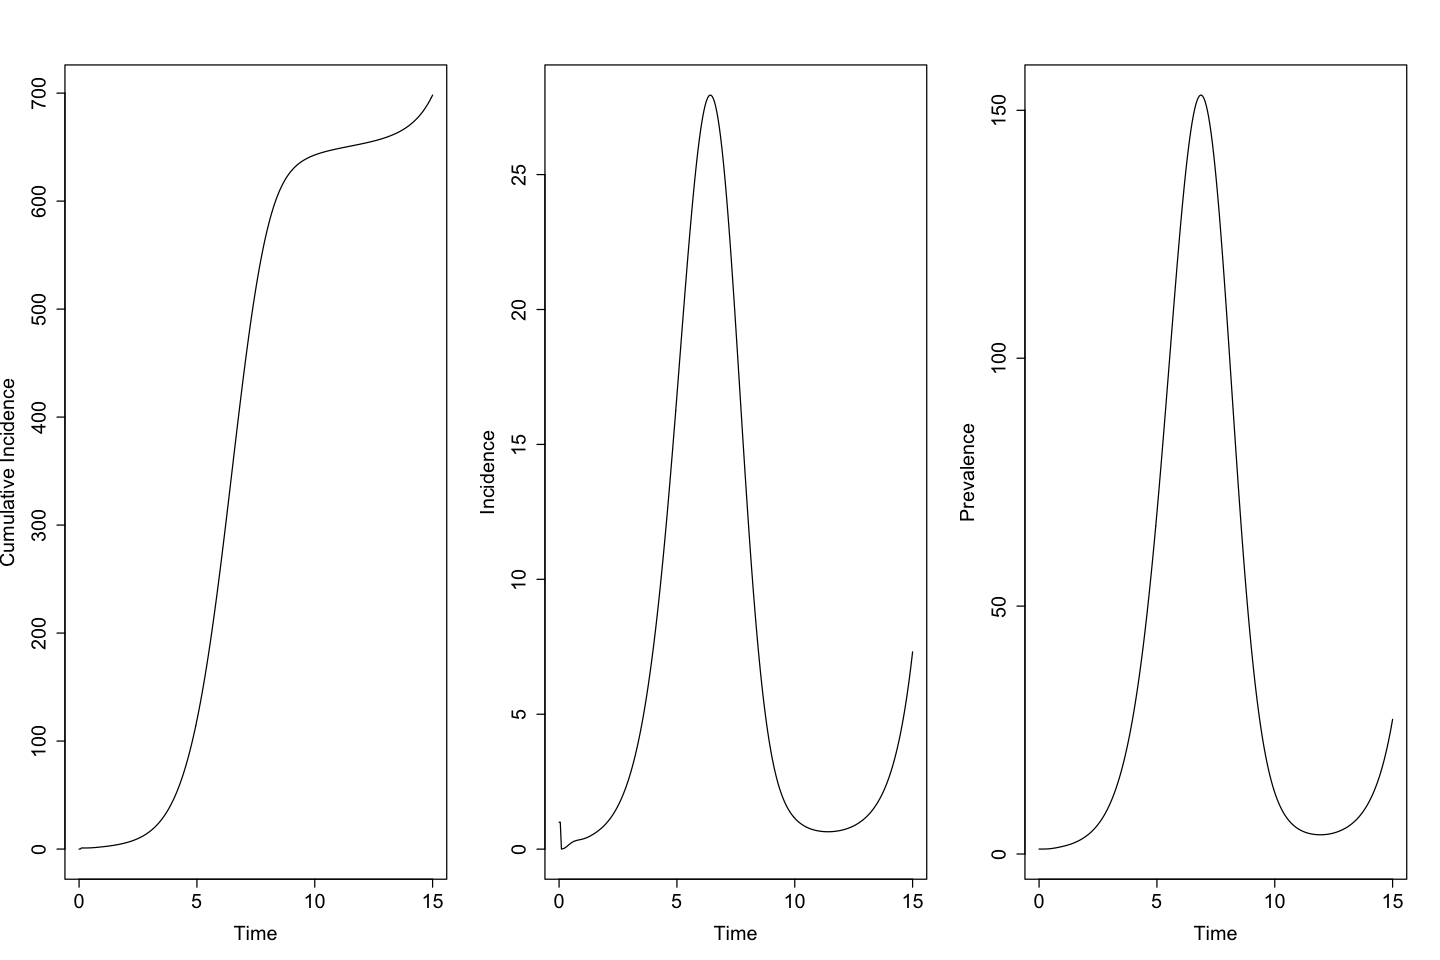

In [2]:
# extract l=0 from the diagnoal of B1, B2 and B3
par(mfrow = c(1,3))
cumulative_incidence <- diag(Bci)
incidence <- diag(Bi)
prevalence <- diag(Bp)

#plotting to visualise
options(repr.plot.width = 12, repr.plot.height = 8)
plot(xx, cumulative_incidence, col = "black", type = "l", ylab = "Cumulative Incidence", 
     xlab = "Time", cex.main = 1.5, cex.lab = 1.5, cex.axis = 1.5)
plot(xx, incidence, col = "black", type = "l", ylab = "Incidence", xlab = "Time", 
     cex.main = 1.5, cex.lab = 1.5, cex.axis = 1.5)
plot(xx, prevalence, col = "black", type = 'l', ylab = "Prevalence", xlab = "Time", 
    cex.main = 1.5, cex.lab = 1.5, cex.axis = 1.5)